# 🌊Tsunami Risk Prediction from Seismic Data

![Tsunami Banner](https://media.istockphoto.com/id/186041798/fr/photo/tsunami-vagues.jpg?s=612x612&w=0&k=20&c=MJWGDf-PzKxA7Os7VPBSt_u6GwAK2Va_Rqeg4_VT_Do=)

## 1. Introduction


### Project Overview

This project investigates whether tsunami potential can be predicted solely from seismic characteristics.
Using machine learning classification models, the goal is to determine if an earthquake is likely to generate a tsunami based on its measurable seismic parameters.
The analysis is based on 782 significant earthquakes recorded worldwide between 2001 and 2022.

### Dataset Summary

The dataset, Global Earthquake–Tsunami Risk Assessment Dataset, provides clean and structured seismic data ready for machine learning applications.

**Total records**: 782 earthquakes

**Time period**: 2001–2022 (22 years)

**Geographic coverage**: Global (Lat: -61.85° to 71.63°, Lon: -179.97° to 179.66°)

**Target variable**: Binary tsunami potential indicator

**Class distribution**: 304 tsunami-related events (38.9%) vs. 478 non-tsunami events (61.1%)

**Features**: 13 seismic attributes including magnitude, depth, and intensity metrics

**Missing values**: None (100% complete dataset)

In [1]:
import numpy as np
import pandas as pd

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Load dataset
df = pd.read_csv('/kaggle/input/global-earthquake-tsunami-risk-assessment-dataset/earthquake_data_tsunami.csv')
print("dataset succesfully loaded")

dataset succesfully loaded


In [2]:
print("STRUCTURE")
print(f"   • Total Records: {df.shape[0]:,}")
print(f"   • Total Features: {df.shape[1]}\n")

print("\n TARGET BALANCE")
tsunami_counts = df['tsunami'].value_counts()
tsunami_pct = df['tsunami'].value_counts(normalize=True) * 100
print(f"   • No Tsunami (0): {tsunami_counts[0]} ({tsunami_pct[0]:.1f}%)")
print(f"   • Tsunami (1): {tsunami_counts[1]} ({tsunami_pct[1]:.1f}%)")

print("\n\nDATA OVERVIEW")
print(df.head())

print("\n\nSTATISTICAL SUMMARY")
df.describe().T



STRUCTURE
   • Total Records: 782
   • Total Features: 13


 TARGET BALANCE
   • No Tsunami (0): 478 (61.1%)
   • Tsunami (1): 304 (38.9%)


DATA OVERVIEW
   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1  


STATISTICAL SUMMARY


,count,mean,std,min,25%,50%,75%,max
magnitude,782.0,6.941125,0.445514,6.5000,6.60000,6.8000,7.1000,9.1000
cdi,782.0,4.333760,3.169939,0.0000,0.00000,5.0000,7.0000,9.0000
mmi,782.0,5.964194,1.462724,1.0000,5.00000,6.0000,7.0000,9.0000
sig,782.0,870.108696,322.465367,650.0000,691.00000,754.0000,909.7500,2910.0000
nst,782.0,230.250639,250.188177,0.0000,0.00000,140.0000,445.0000,934.0000
dmin,782.0,1.325757,2.218805,0.0000,0.00000,0.0000,1.8630,17.6540
gap,782.0,25.038990,24.225067,0.0000,14.62500,20.0000,30.0000,239.0000
depth,782.0,75.883199,137.277078,2.7000,14.00000,26.2950,49.7500,670.8100
latitude,782.0,3.538100,27.303429,-61.8484,-14.59560,-2.5725,24.6545,71.6312
longitude,782.0,52.609199,117.898886,-179.9680,-71.66805,109.4260,148.9410,179.6620


## 2. Exploratory Data Analysis

<Figure size 1600x1200 with 0 Axes>

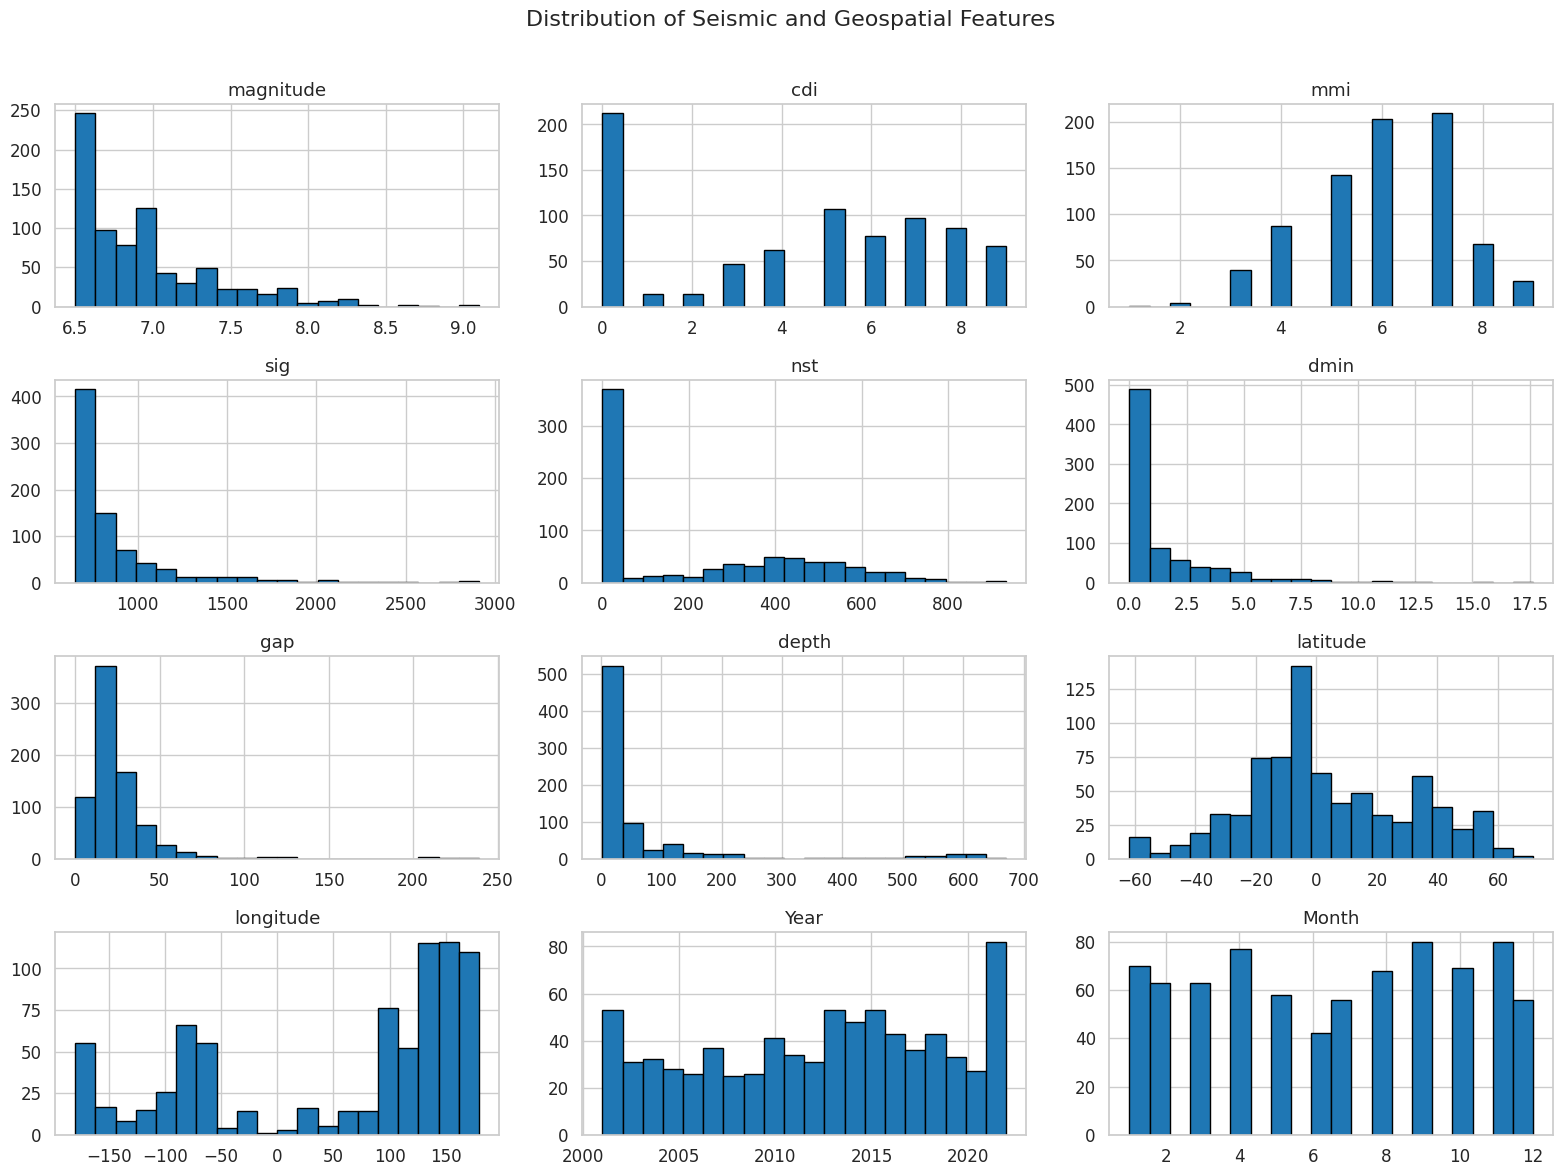

In [3]:
# EDA #1: Distribution of Numeric Features
numeric_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'tsunami']
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(16, 12))
df[numeric_features].hist(bins=20, figsize=(16, 12), color="#1f77b4", edgecolor="black")
plt.suptitle("Distribution of Seismic and Geospatial Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

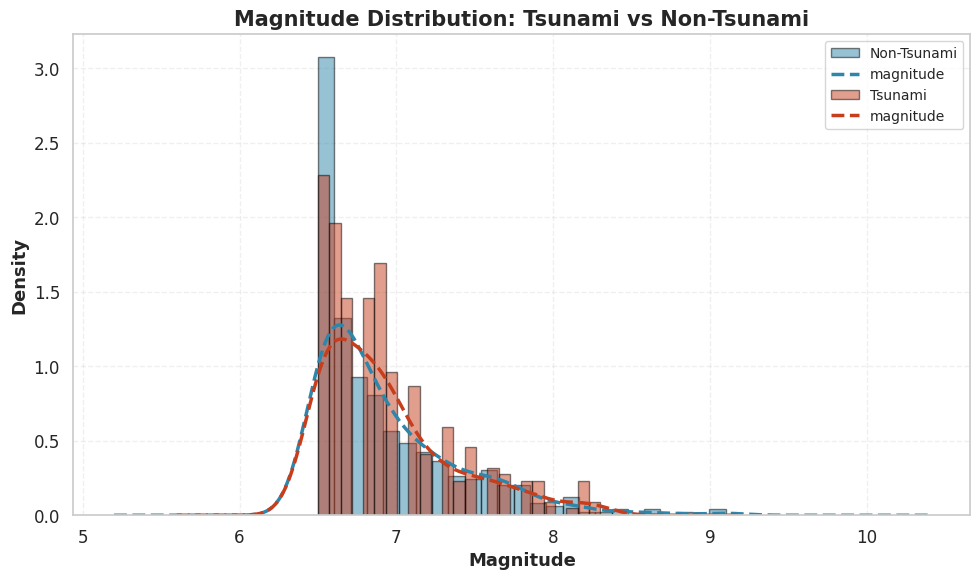

In [4]:
# EDA #2: Magnitude Distribution by Tsunami Status
fig, ax = plt.subplots(figsize=(10, 6))

for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['magnitude']
    
    ax.hist(data, bins=25, alpha=0.5, label=label, color=color, edgecolor='black', density=True)
    
    data.plot(kind='kde', ax=ax, color=color, linewidth=2.5, linestyle='--')


ax.set_xlabel('Magnitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Density', fontsize=13, fontweight='bold')
ax.set_title('Magnitude Distribution: Tsunami vs Non-Tsunami', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

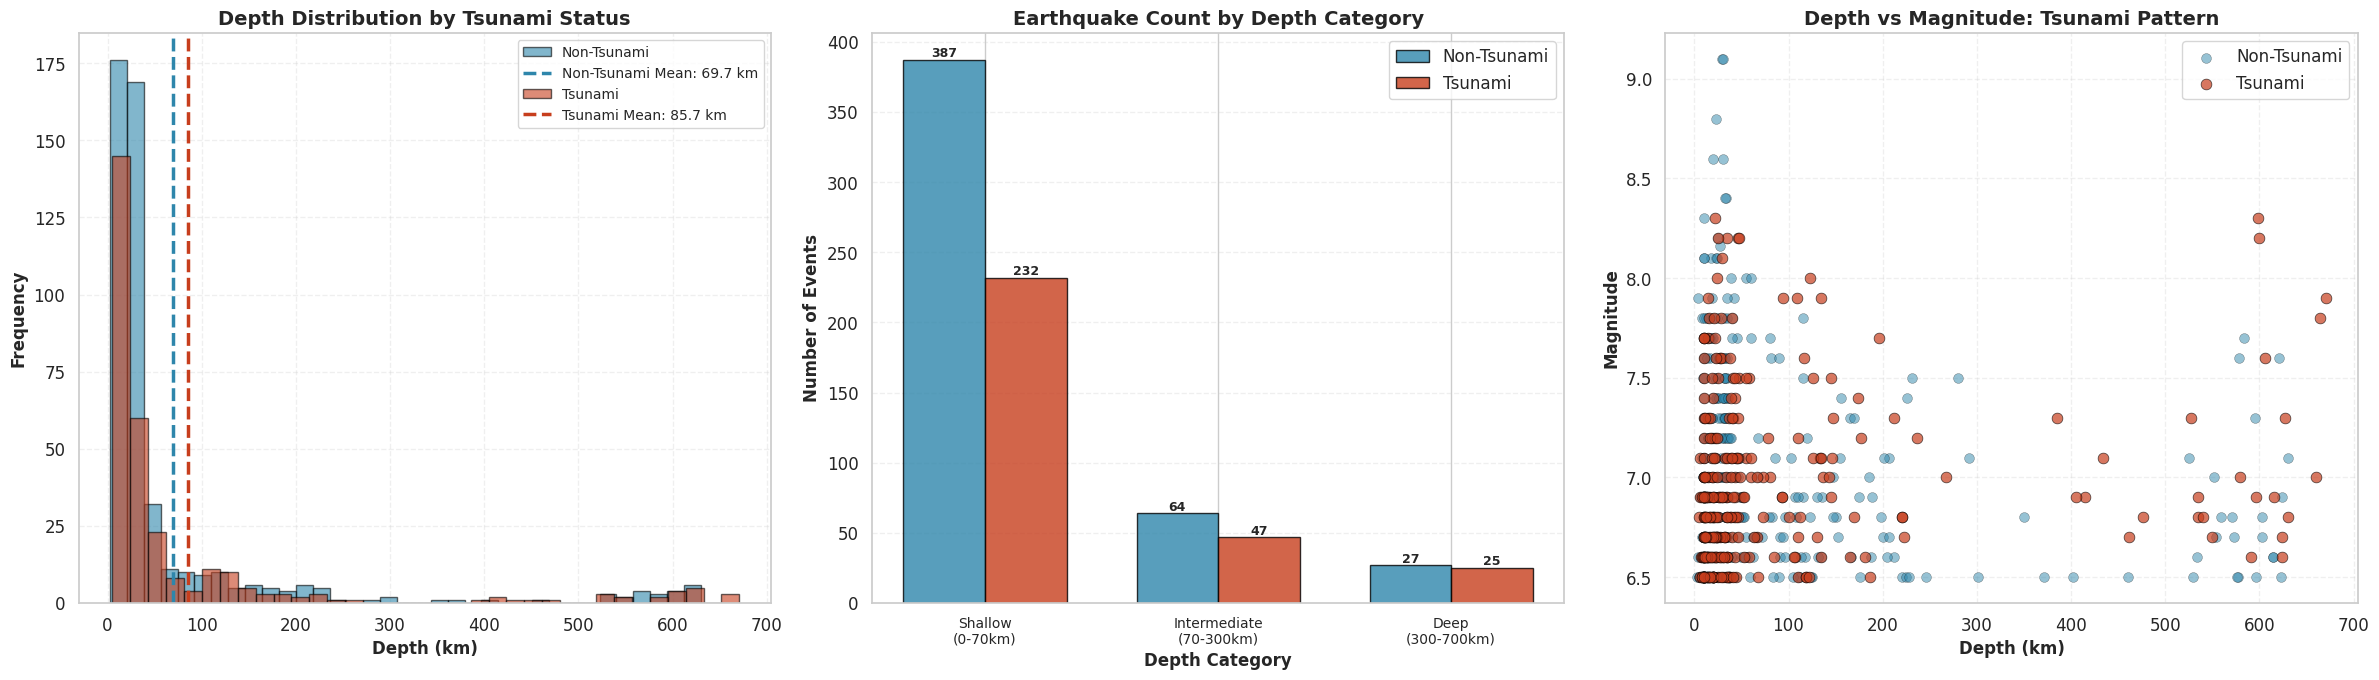

In [5]:
# EDA #3: Depth Distribution
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['depth']
    axes[0].hist(data, bins=35, alpha=0.6, label=label, color=color, edgecolor='black')
    axes[0].axvline(data.mean(), color=color, linestyle='--', linewidth=2.5,
                   label=f'{label} Mean: {data.mean():.1f} km')

axes[0].set_xlabel('Depth (km)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Depth Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')

df['depth_category'] = pd.cut(df['depth'], bins=[0, 70, 300, 700], 
                              labels=['Shallow\n(0-70km)', 'Intermediate\n(70-300km)', 'Deep\n(300-700km)'])
depth_tsunami = df.groupby(['depth_category', 'tsunami'], observed=False).size().unstack(fill_value=0)

x = np.arange(len(depth_tsunami.index))
width = 0.35

bars1 = axes[1].bar(x - width/2, depth_tsunami[0], width, label='Non-Tsunami', 
                    color='#2E86AB', edgecolor='black', alpha=0.8)
bars2 = axes[1].bar(x + width/2, depth_tsunami[1], width, label='Tsunami',
                    color='#C73E1D', edgecolor='black', alpha=0.8)

axes[1].set_xlabel('Depth Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[1].set_title('Earthquake Count by Depth Category', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(depth_tsunami.index, fontsize=10)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y', linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3: Scatter - Depth vs Magnitude
tsunami_events = df[df['tsunami'] == 1]
non_tsunami_events = df[df['tsunami'] == 0]

axes[2].scatter(non_tsunami_events['depth'], non_tsunami_events['magnitude'], 
                alpha=0.5, s=50, c='#2E86AB', edgecolors='black', linewidth=0.3, label='Non-Tsunami')
axes[2].scatter(tsunami_events['depth'], tsunami_events['magnitude'],
                alpha=0.7, s=60, c='#C73E1D', edgecolors='black', linewidth=0.5, label='Tsunami')

axes[2].set_xlabel('Depth (km)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Magnitude', fontsize=12, fontweight='bold')
axes[2].set_title('Depth vs Magnitude: Tsunami Pattern', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

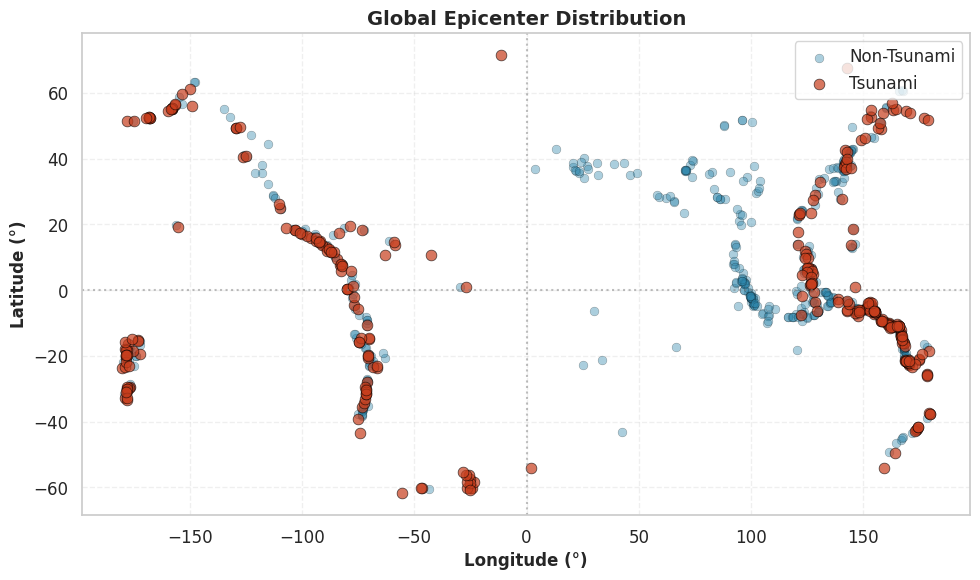

In [6]:
# EDA #4: Geographic Distribution
fig, ax = plt.subplots(figsize=(10, 6))

# 2D scatter plot (Global Epicenter Distribution
ax.scatter(df[df['tsunami']==0]['longitude'], df[df['tsunami']==0]['latitude'],
           alpha=0.4, s=40, c='#2E86AB', edgecolors='black', linewidth=0.3, label='Non-Tsunami')
ax.scatter(df[df['tsunami']==1]['longitude'], df[df['tsunami']==1]['latitude'],
           alpha=0.7, s=60, c='#C73E1D', edgecolors='black', linewidth=0.5, label='Tsunami')

ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
ax.set_title('Global Epicenter Distribution', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3, linestyle='--')
ax.axhline(0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5) # Ligne pour l'équateur
ax.axvline(0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5) # Ligne pour le méridien de Greenwich

plt.tight_layout()
plt.show()


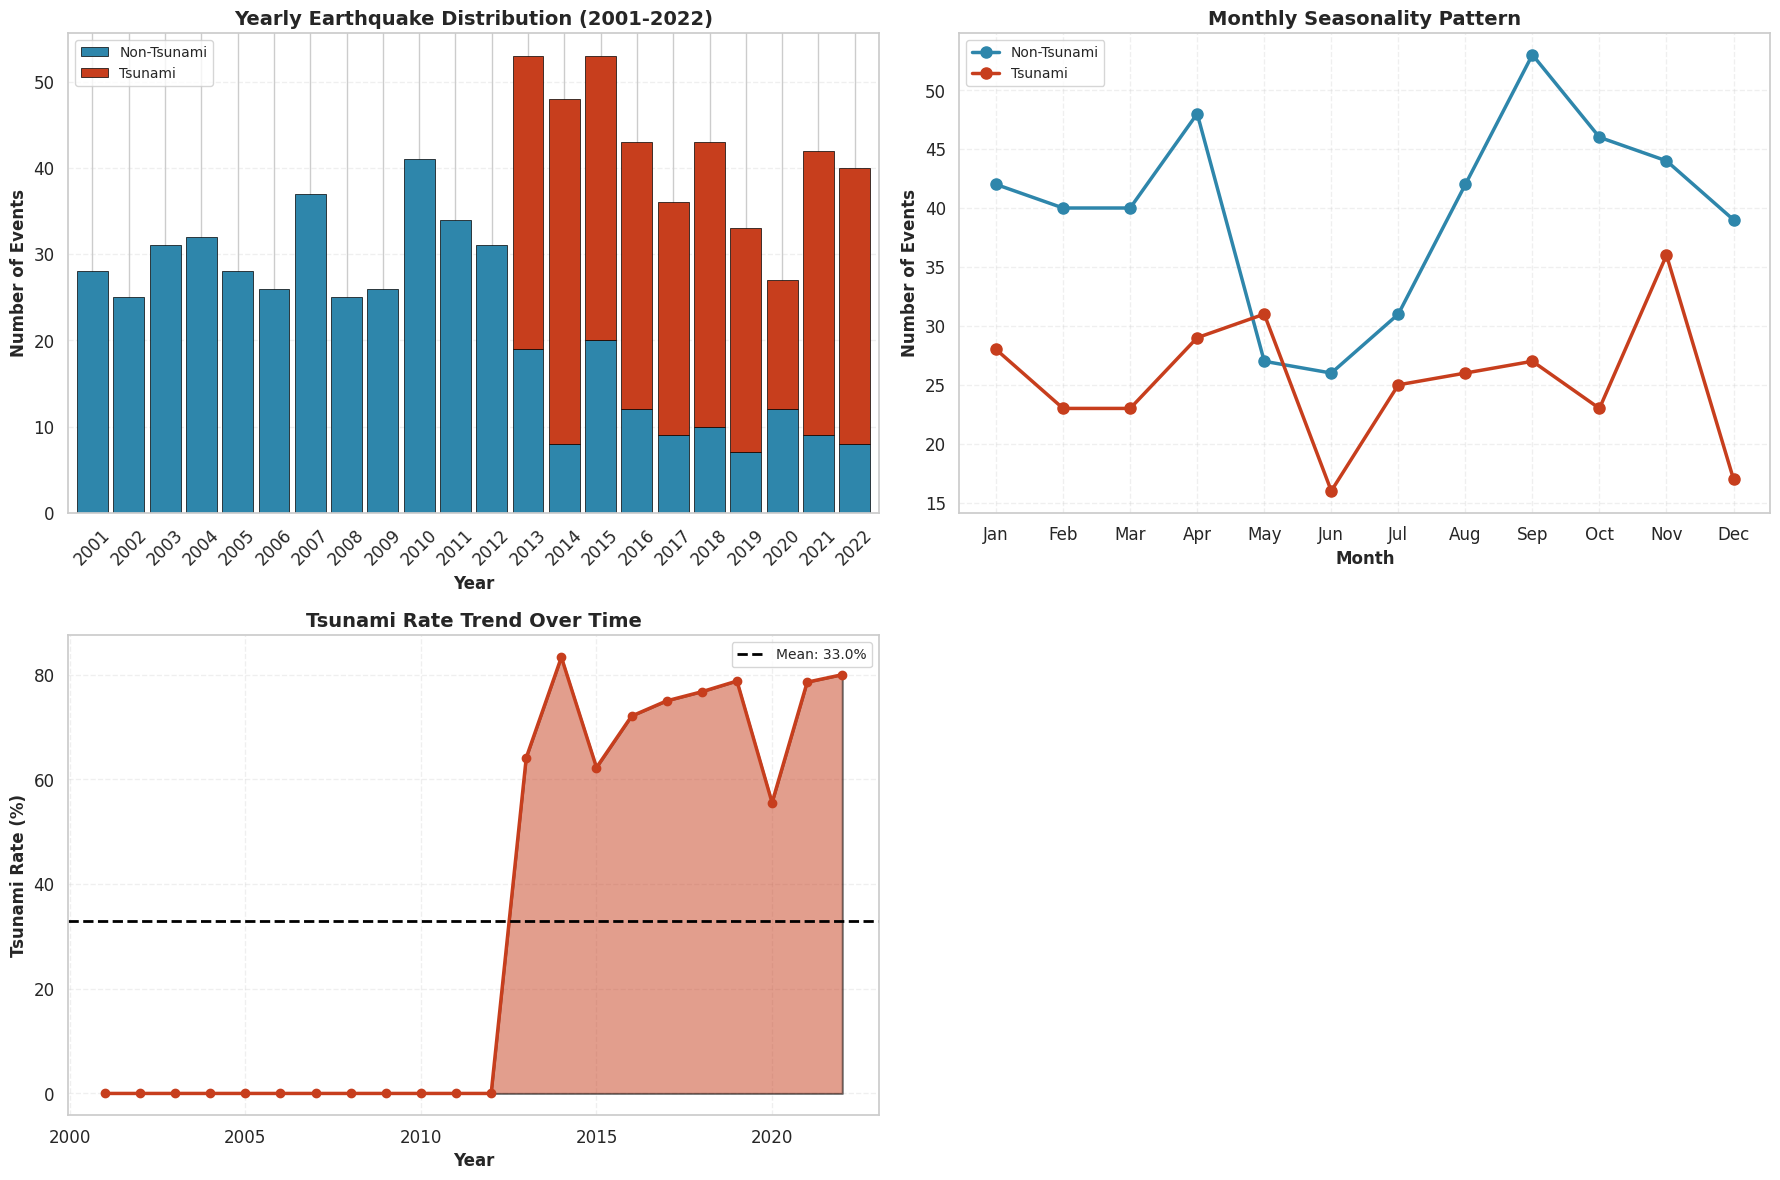

In [7]:
# EDA #5: Temporal Patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Yearly trend
yearly_data = df.groupby(['Year', 'tsunami']).size().unstack(fill_value=0)
yearly_data.plot(kind='bar', stacked=True, color=['#2E86AB', '#C73E1D'], ax=axes[0,0], 
                 width=0.85, edgecolor='black', linewidth=0.5)
axes[0,0].set_title('Yearly Earthquake Distribution (2001-2022)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[0,0].legend(['Non-Tsunami', 'Tsunami'], loc='upper left', fontsize=10)
axes[0,0].grid(alpha=0.3, axis='y', linestyle='--')
axes[0,0].tick_params(axis='x', rotation=45)

# Top-right: Monthly patterns
monthly_data = df.groupby(['Month', 'tsunami']).size().unstack(fill_value=0)
monthly_data.plot(kind='line', marker='o', color=['#2E86AB', '#C73E1D'], ax=axes[0,1], 
                  linewidth=2.5, markersize=8)
axes[0,1].set_title('Monthly Seasonality Pattern', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0,1].legend(['Non-Tsunami', 'Tsunami'], loc='upper left', fontsize=10)
axes[0,1].grid(alpha=0.3, linestyle='--')

# Bottom-left: Tsunami rate by year
tsunami_rate_yearly = df.groupby('Year')['tsunami'].mean() * 100
axes[1,0].fill_between(tsunami_rate_yearly.index, tsunami_rate_yearly.values, 
                       color='#C73E1D', alpha=0.5, edgecolor='black', linewidth=1.5)
axes[1,0].plot(tsunami_rate_yearly.index, tsunami_rate_yearly.values, 
               color='#C73E1D', linewidth=2.5, marker='o', markersize=6)
axes[1,0].axhline(y=tsunami_rate_yearly.mean(), color='black', linestyle='--', 
                  linewidth=2, label=f'Mean: {tsunami_rate_yearly.mean():.1f}%')
axes[1,0].set_title('Tsunami Rate Trend Over Time', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Tsunami Rate (%)', fontsize=12, fontweight='bold')
axes[1,0].legend(fontsize=10)
axes[1,0].grid(alpha=0.3, linestyle='--')

axes[1,1].axis('off')
plt.tight_layout()
plt.show()

### Addressing Data Integrity: Resolving Temporal Bias
During the exploratory data analysis (EDA), I identified a critical representation bias in the dataset's temporal distribution. (cf. "Tsunami Rate Over Time" graph)

Observation: All earthquake records from 2001 to 2011 (pre-2012) are exclusively negative cases (labeled tsunami = 0). In contrast, the data from 2012 onwards contains a realistic mix of both positive (tsunami = 1) and negative (tsunami = 0) events.

Implication: This bias means the pre-2012 data is an incomplete and non-representative sample. If used, a model would suffer from data leakage, learning a spurious correlation: it would incorrectly associate the Year itself with the outcome (e.g., "If Year < 2012, then Tsunami = 0").

Action Taken: To build a valid and generalizable model, all records from the biased pre-2012 period were removed. The model will be trained and evaluated only on the representative data from 2012-2022. This forces the model to learn from the true physical predictors (magnitude, depth, location) rather than a temporal anomaly in the data.

<Axes: >

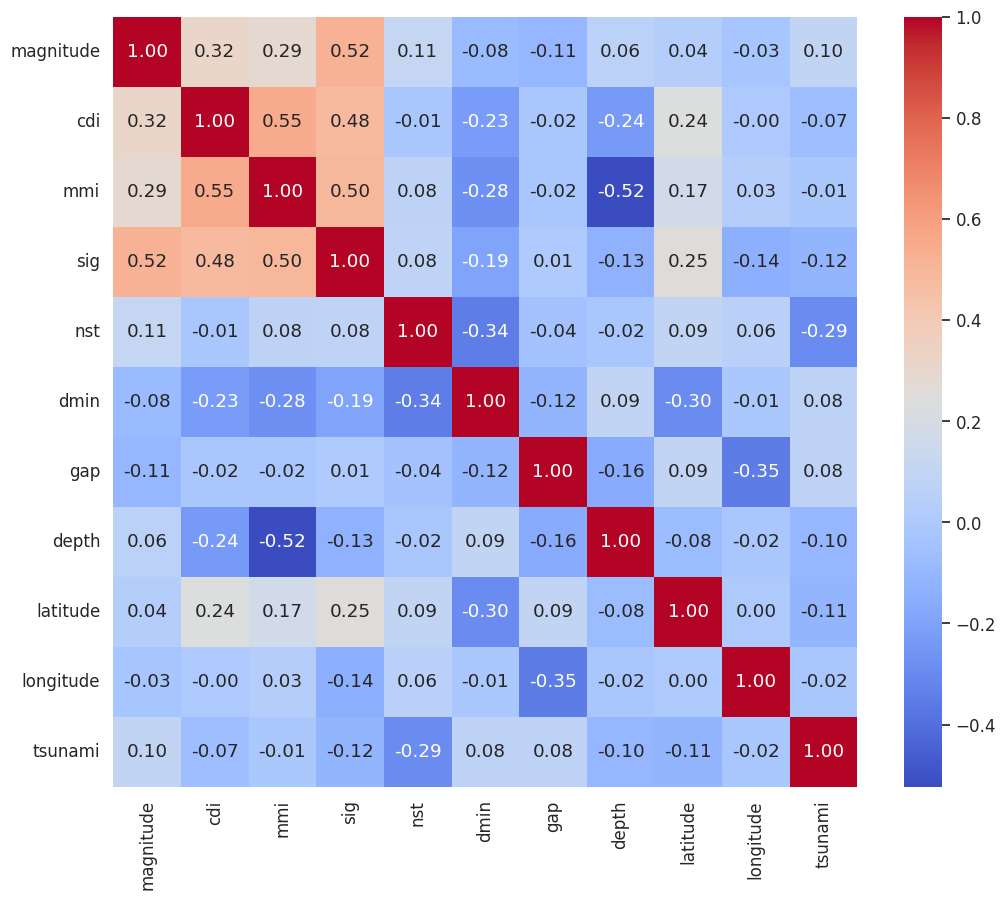

In [8]:
# EDA #6: Pearson Correlation Heatmap
df_corrected = df[df['Year'] >= 2012].copy()
df_corrected = df_corrected.drop(columns=['Year', 'Month'])

corr_matrix2 = df_corrected.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix2,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
)

## 3. Feature Engineering

### V2 Feature Engineering — Integrating Geospatial Intelligence

The V1 model achieved 95% Recall on tsunami events, but only 0.62 Recall on non-tsunamis, indicating a high false-positive rate.
This suggests the model may rely on indirect location-based proxies (e.g., latitude, longitude, pacific_region) rather than true physical indicators.

To address this, we introduce a new geospatial feature: distance_to_fault_km, computed using **GeoPandas** and **Shapely**.
This variable measures the precise distance (in kilometers) from each earthquake’s epicenter to the nearest tectonic plate boundary, a physically meaningful predictor of tsunami potential.

The goal is to determine whether adding this geospatial signal can help the model reduce false positives (improve Non-Tsunami Recall) without compromising Tsunami Recall, which remains the critical performance metric.

In [9]:
import geopandas as gpd
from shapely.geometry import Point

print("─── [START] Geospatial Feature Engineering ───")

# ============================================================
# 1. Load Tectonic Fault Boundaries
# ============================================================
try:
    gdf_faults = gpd.read_file('/kaggle/input/tectonic-plates-boundaries/PB2002_boundaries.json')
    print("✓ Tectonic fault boundaries successfully loaded.")
except Exception as e:
    print("ERROR: Failed to load tectonic fault file.")
    raise e

# ============================================================
# 2. Convert Earthquake Dataset to GeoDataFrame
# ============================================================
# Each earthquake (latitude, longitude) is converted to a geometric Point
geometry = [Point(xy) for xy in zip(df_corrected['longitude'], df_corrected['latitude'])]
gdf_earthquakes = gpd.GeoDataFrame(
    df_corrected,
    geometry=geometry,
    crs="EPSG:4326"  # WGS84: standard geographic coordinate reference system
)
print("✓ Earthquake data successfully converted to GeoDataFrame.")

# ============================================================
# 3. Ensure Consistent Coordinate Reference Systems (CRS)
# ============================================================
gdf_faults = gdf_faults.to_crs(gdf_earthquakes.crs)
print("✓ CRS alignment completed (EPSG:4326).")

# ============================================================
# 4. Project Data into Metric CRS (for distance computation)
# ============================================================
print("⟳ Projecting geometries to metric CRS (EPSG:3857)...")
gdf_eq_projected = gdf_earthquakes.to_crs("EPSG:3857")
gdf_faults_projected = gdf_faults.to_crs("EPSG:3857")
print("✓ Projection successful (units in meters).")

# ============================================================
# 5. Merge All Fault Lines into a Single Geometry
# ============================================================
# This allows faster distance computation against all faults simultaneously
all_fault_lines = gdf_faults_projected.geometry.unary_union
print(f"✓ Fault lines merged into a unified geometry ({len(gdf_faults)} segments).")

# Optional quick geometry check (for debugging)
#print(gdf_faults.geometry.geom_type.unique())
#print(gdf_faults.crs)

# ============================================================
# 6. Compute Distance from Each Earthquake to Nearest Fault Line
# ============================================================
print("⟳ Computing distances from earthquakes to nearest tectonic fault...")
def get_distance_to_fault(point_geom):
    return all_fault_lines.distance(point_geom)

df_corrected['distance_to_fault_m'] = gdf_eq_projected.geometry.apply(get_distance_to_fault)
print("✓ Distance computation completed.")

# ============================================================
# 7. Convert to Kilometers & Clean Up Temporary Columns
# ============================================================
df_corrected['distance_to_fault_km'] = df_corrected['distance_to_fault_m'] / 1000.0
df_corrected.drop(['distance_to_fault_m', 'geometry'], axis=1, errors='ignore', inplace=True)
print("✓ New feature 'distance_to_fault_km' successfully added to dataset.")

# ============================================================
# 8. Final Summary
# ============================================================
print("\n─── [SUMMARY] ───────────────────────────────")
print(df_corrected[['magnitude', 'tsunami', 'distance_to_fault_km']].head(10))
print("─── [END] Geospatial Feature Engineering ───")


─── [START] Geospatial Feature Engineering ───
✓ Tectonic fault boundaries successfully loaded.
✓ Earthquake data successfully converted to GeoDataFrame.
✓ CRS alignment completed (EPSG:4326).
⟳ Projecting geometries to metric CRS (EPSG:3857)...
✓ Projection successful (units in meters).
✓ Fault lines merged into a unified geometry (241 segments).
⟳ Computing distances from earthquakes to nearest tectonic fault...
✓ Distance computation completed.
✓ New feature 'distance_to_fault_km' successfully added to dataset.

─── [SUMMARY] ───────────────────────────────
   magnitude  tsunami  distance_to_fault_km
0        7.0        1             26.205165
1        6.9        0             16.640424
2        7.0        1            222.977711
3        7.3        1             86.671806
4        6.6        1            577.480437
5        7.0        1            629.557948
6        6.8        1            620.658053
7        6.7        1             45.195698
8        6.8        1             88.

In [10]:
df_features = df_corrected.copy()

# 1. MAGNITUDE-DEPTH INTERACTION (Critical for tsunami prediction)
df_features['mag_depth_ratio'] = df_features['magnitude'] / (df_features['depth'] + 1)
print("✓ Created magnitude-depth interaction features")

# 2. DEPTH CATEGORIES (Shallow earthquakes => higher tsunami risk)
df_features['is_shallow'] = (df_features['depth'] <= 70).astype(int)

# Oceanic zones (Pacific Ring of Fire indicators)
df_features['pacific_region'] = ((df_features['longitude'] >= 120) | (df_features['longitude'] <= -60)).astype(int)
print("✓ Created geographic features")


print(f" Original features: {df_corrected.shape[1]}")
print(f" Total features after engineering: {df_features.shape[1]}")
print(f" New features created: {df_features.shape[1] - df_corrected.shape[1]}")
print("="*70)

# Show sample of new features
print("\nSample of Engineered Features:\n")
new_features = ['mag_depth_ratio', 'is_shallow', 'pacific_region', 'distance_to_fault_km']
df_features[new_features + ['tsunami']].head()

✓ Created magnitude-depth interaction features
✓ Created geographic features
 Original features: 13
 Total features after engineering: 16
 New features created: 3

Sample of Engineered Features:



,mag_depth_ratio,is_shallow,pacific_region,distance_to_fault_km,tsunami
0,0.466667,1,1,26.205165,1
1,0.265385,1,0,16.640424,0
2,0.012069,0,1,222.977711,1
3,0.192105,1,1,86.671806,1
4,0.010552,0,1,577.480437,1


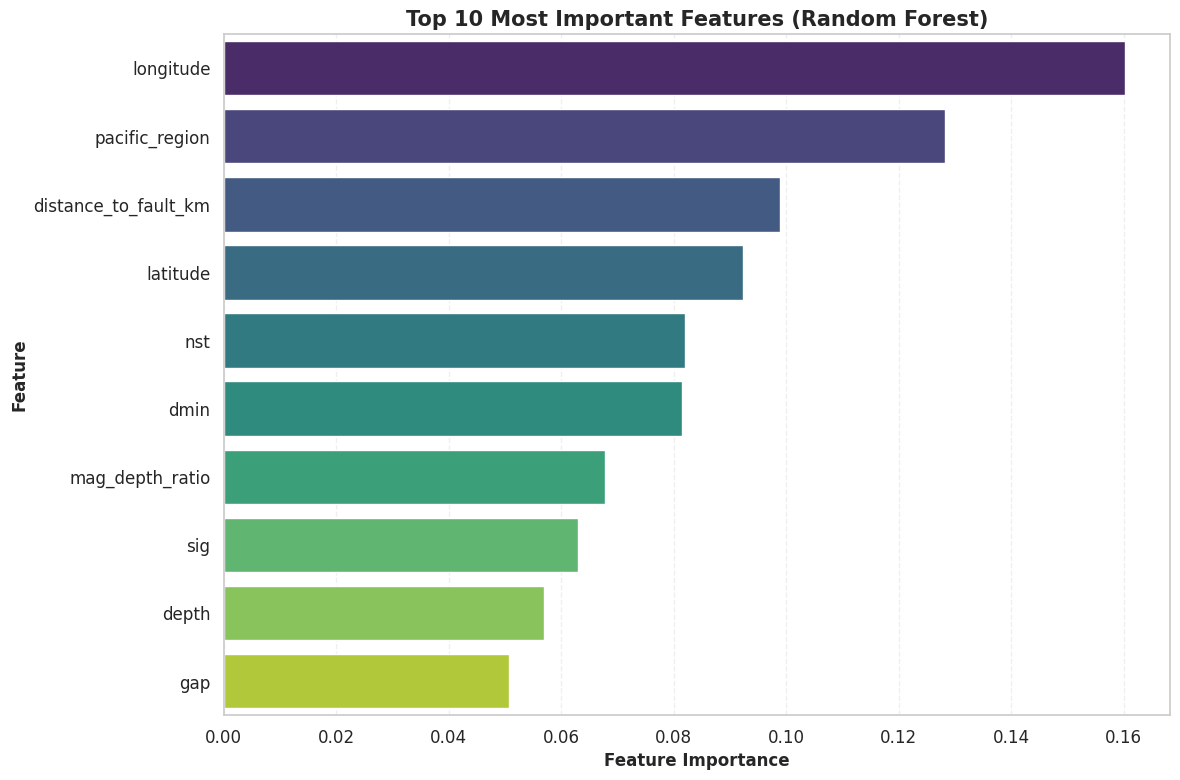

_______________________________________________
TOP 5 MOST IMPORTANT FEATURES
_______________________________________________
longitude............................... 0.1603
pacific_region.......................... 0.1282
distance_to_fault_km.................... 0.0989
latitude................................ 0.0924
nst..................................... 0.0820
_______________________________________________


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data (select only numeric features)
X_temp = df_features.select_dtypes(include=[np.number]).drop(['tsunami'], axis=1, errors='ignore')
y_temp = df_features['tsunami']

# Handle any remaining categorical columns
for col in X_temp.columns:
    if X_temp[col].dtype == 'object' or X_temp[col].dtype.name == 'category':
        X_temp = X_temp.drop(col, axis=1)

# Quick RF for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False).head(10)

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis', ax=ax)
ax.set_title('Top 10 Most Important Features (Random Forest)', fontsize=15, fontweight='bold')
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x', linestyle='--')

plt.tight_layout()
plt.show()

print("_"*47)
print("TOP 5 MOST IMPORTANT FEATURES")
print("_"*47)
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']:.<40} {row['importance']:.4f}")
print("_"*47)

In [12]:
df_features.columns

Index(['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth',
       'latitude', 'longitude', 'tsunami', 'depth_category',
       'distance_to_fault_km', 'mag_depth_ratio', 'is_shallow',
       'pacific_region'],
      dtype='object')

## 4. ML Model development

In [13]:
# ================================================================
# Data Preparation & Pipeline Definition
# ================================================================

# ------------------------------------------------
# Step 1 — Feature & Target Selection
# ------------------------------------------------

# Columns to drop (non-predictive or derived categories)
drop_cols = ['tsunami', 'depth_category', 'magnitude_category', 'depth_risk_category']

# Keep only relevant numeric features
X = df_features.drop(drop_cols, axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])

# Target variable
y = df_features['tsunami']

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Number of features: {X.shape[1]}")

# ------------------------------------------------
# Step 2 — Stratified Train/Test Split
# ------------------------------------------------
# Ensures both sets maintain class balance (important due to rare tsunami events)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Training set: {X_train.shape[0]} samples ({y_train.sum()} tsunami events)")
print(f"✓ Test set: {X_test.shape[0]} samples ({y_test.sum()} tsunami events)")
print(f"✓ Train tsunami rate: {y_train.mean()*100:.1f}%")
print(f"✓ Test tsunami rate: {y_test.mean()*100:.1f}%\n")

# ------------------------------------------------
# Step 3 — Handling Class Imbalance
# ------------------------------------------------
# Compute class weighting for XGBoost (helps balance rare tsunami events)
scale_pos_weight = (y_train == 0).sum() / y_train.sum()

# ------------------------------------------------
# Step 4 — Define Candidate Models (Pipelines)
# ------------------------------------------------
# Each model is wrapped in a pipeline to ensure consistent scaling and clean evaluation

pipelines = {
    'Logistic Regression': make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    ),
    'SVM': make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
    ),
    'KNN': make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5)
    ),
    'Random Forest': make_pipeline(
        RandomForestClassifier(
            n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'
        )
    ),
    'Gradient Boosting': make_pipeline(
        GradientBoostingClassifier(n_estimators=200, random_state=42)
    ),
    'XGBoost': make_pipeline(
        XGBClassifier(
            n_estimators=200, random_state=42, eval_metric='logloss',
            scale_pos_weight=scale_pos_weight, use_label_encoder=False
        )
    ),
    'LightGBM': make_pipeline(
        LGBMClassifier(
            n_estimators=200, random_state=42, verbose=-1, class_weight='balanced'
        )
    ),
    'AdaBoost': make_pipeline(
        AdaBoostClassifier(n_estimators=200, random_state=42)
    )
}

print(f"✓ {len(pipelines)} pipelines defined successfully.")


✓ Features shape: (449, 14)
✓ Target shape: (449,)
✓ Number of features: 14

✓ Training set: 359 samples (243 tsunami events)
✓ Test set: 90 samples (61 tsunami events)
✓ Train tsunami rate: 67.7%
✓ Test tsunami rate: 67.8%

✓ 8 pipelines defined successfully.


In [14]:
print("\n" + "="*70)
print("Model Comparison using Cross-Validation")
print("="*70)

# Define a robust stratified cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(
    n_splits=10,    # 10 folds — good balance for small datasets
    n_repeats=3,    # Repeats CV to reduce variance
    random_state=42
)

cv_results = []
trained_models = {}  # Store trained models if needed later

for name, pipeline in pipelines.items():
    print(f"\n  Validation de {name}...")
    
    # Evaluate model with multiple metrics via cross-validation
    scores = cross_validate(pipeline, X_train, y_train, cv=cv_strategy, 
                            scoring=['f1', 'recall', 'roc_auc'], 
                            n_jobs=-1)  # Parallel computation for speed
    
    # Store mean performance metrics
    cv_results.append({
        'Model': name,
        'F1 (mean)': scores['test_f1'].mean(),
        'Recall (mean)': scores['test_recall'].mean(),
        'ROC-AUC (mean)': scores['test_roc_auc'].mean(),
        'Fit Time (mean)': scores['fit_time'].mean()
    })
    
    # Display summary for current model
    print(f"    ✓ F1: {scores['test_f1'].mean():.4f} | Recall: {scores['test_recall'].mean():.4f} | ROC-AUC: {scores['test_roc_auc'].mean():.4f}")

# Create and sort final CV results table
cv_results_df = pd.DataFrame(cv_results).sort_values('F1 (mean)', ascending=False)


Model Comparison using Cross-Validation

  Validation de Logistic Regression...
    ✓ F1: 0.8398 | Recall: 0.8149 | ROC-AUC: 0.8321

  Validation de SVM...
    ✓ F1: 0.8606 | Recall: 0.8546 | ROC-AUC: 0.8487

  Validation de KNN...
    ✓ F1: 0.8526 | Recall: 0.8890 | ROC-AUC: 0.8152

  Validation de Random Forest...
    ✓ F1: 0.9004 | Recall: 0.9506 | ROC-AUC: 0.9083

  Validation de Gradient Boosting...
    ✓ F1: 0.9021 | Recall: 0.9287 | ROC-AUC: 0.9079

  Validation de XGBoost...
    ✓ F1: 0.8803 | Recall: 0.8902 | ROC-AUC: 0.8804

  Validation de LightGBM...
    ✓ F1: 0.8750 | Recall: 0.8916 | ROC-AUC: 0.8789

  Validation de AdaBoost...
    ✓ F1: 0.8493 | Recall: 0.8587 | ROC-AUC: 0.8449


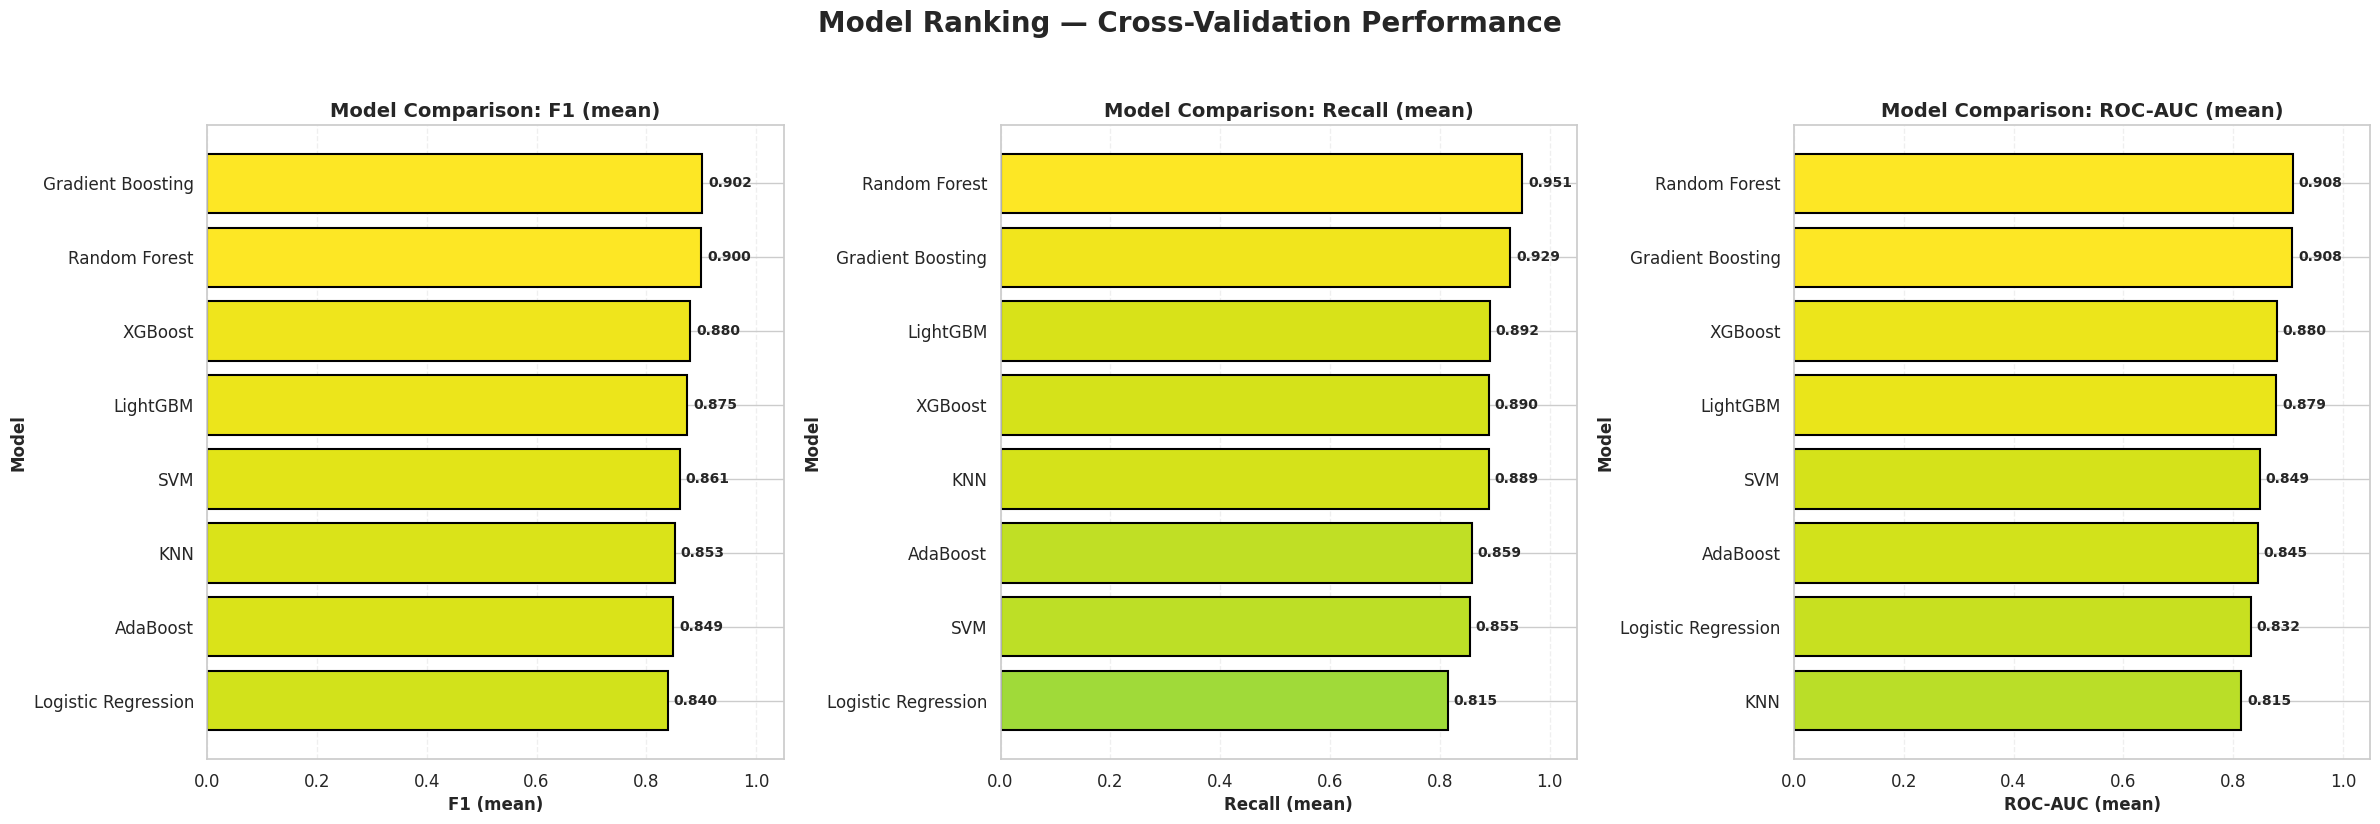


____________________________________________________________
FINAL MODEL RANKING (by mean CV F1-Score)
____________________________________________________________
1. Gradient Boosting              F1: 0.9021
2. Random Forest                  F1: 0.9004
3. XGBoost                        F1: 0.8803
4. LightGBM                       F1: 0.8750
5. SVM                            F1: 0.8606
6. KNN                            F1: 0.8526
7. AdaBoost                       F1: 0.8493
8. Logistic Regression            F1: 0.8398
____________________________________________________________


In [15]:
# ================================================================
# Cross-Validation Results Visualization & Model Ranking
# ================================================================

# ------------------------------------------------
# Step 1 — Visualize Cross-Validation Performance
# ------------------------------------------------
# Display 3 key metrics side-by-side for model comparison

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
metrics = ['F1 (mean)', 'Recall (mean)', 'ROC-AUC (mean)']

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    # Sort models by current metric
    data = cv_results_df.sort_values(metric, ascending=True)
    
    # Normalize color intensity according to metric value
    norm_colors = data[metric] / data[metric].max()

    # Horizontal bar chart for visual clarity
    bars = ax.barh(
        data['Model'],
        data[metric],
        color=plt.cm.viridis(norm_colors),
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add score labels next to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.3f}',
            ha='left', va='center',
            fontweight='bold',
            fontsize=10
        )
    
    # Axis labels and titles
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    
    # Consistent X-axis range for readability
    ax.set_xlim(0, 1.05)
    ax.grid(alpha=0.3, axis='x', linestyle='--')

plt.suptitle('Model Ranking — Cross-Validation Performance', fontsize=20, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Step 2 — Final Textual Summary
# ------------------------------------------------
# Print a clean, ranked summary of models by F1-Score

print("\n" + "_"*60)
print("FINAL MODEL RANKING (by mean CV F1-Score)")
print("_"*60)

# Sort results by F1-score for ranking
final_ranking = cv_results_df.sort_values('F1 (mean)', ascending=False).reset_index(drop=True)

for idx, row in final_ranking.iterrows():
    print(f"{idx + 1}. {row['Model']:<30} F1: {row['F1 (mean)']:.4f}")

print("_"*60)


In [16]:
# ================================================================
# 🔧 Step 4 — Hyperparameter Optimization of Top Models
# ================================================================
# Goal: Optimize the two best-performing models (Gradient Boosting & Random Forest)
# using GridSearchCV with our robust cross-validation strategy.

from sklearn.model_selection import GridSearchCV, cross_val_score

print("\n" + "_"*70)
print("STEP 4 — OPTIMIZATION (HYPERPARAMETER TUNING) OF THE TOP 2 MODELS")
print("_"*70)

# ------------------------------------------------
# Step 4.1 — Define Parameter Grids
# ------------------------------------------------
# Each parameter grid explores a balanced search space (not too large for runtime, but rich enough for optimization)

param_grid_gb = {
    'gradientboostingclassifier__n_estimators': [100, 200, 300],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

# Define which models to tune, their pipelines, parameter grids, and target metric
models_to_tune = [
    {
        'name': 'Gradient Boosting',
        'pipeline': pipelines['Gradient Boosting'],
        'param_grid': param_grid_gb,
        'scoring': 'f1'
    },
    {
        'name': 'Random Forest',
        'pipeline': pipelines['Random Forest'],
        'param_grid': param_grid_rf,
        'scoring': 'recall'
    }
]

tuning_results = []
best_overall_model = None
best_overall_score = 0.0

# ------------------------------------------------
# Step 4.2 — Run GridSearchCV for Each Model
# ------------------------------------------------
# We use our robust cross-validation strategy (cv_strategy)
# Each model focuses on its primary metric (F1 or Recall)

for model_spec in models_to_tune:
    name = model_spec['name']
    pipeline = model_spec['pipeline']
    param_grid = model_spec['param_grid']
    scoring_metric = model_spec['scoring']
    
    print(f"\n--- Tuning {name} (focus: {scoring_metric}) ---")
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_strategy,          # Reuse our robust CV (Repeated Stratified K-Fold)
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit search on training data
    grid_search.fit(X_train, y_train)
    
    # Display best results
    print(f"\n✓ Best {scoring_metric} score for {name}: {grid_search.best_score_:.4f}")
    print(f"✓ Best Parameters: {grid_search.best_params_}")
    
    # Store results
    tuning_results.append({
        'Model': name,
        'Best Score': grid_search.best_score_,
        'Metric Used': scoring_metric,
        'Best Params': grid_search.best_params_,
        'Best Estimator': grid_search.best_estimator_
    })

# ------------------------------------------------
# Step 4.3 — Final Model Comparison (by F1-Score)
# ------------------------------------------------
# Gradient Boosting optimized for F1; Random Forest optimized for Recall.
# To compare fairly, we re-evaluate both models using F1 as a common metric.

rf_tuned_estimator = tuning_results[1]['Best Estimator']
gb_tuned_estimator = tuning_results[0]['Best Estimator']

# Compute F1-scores under the same CV strategy
f1_score_rf_tuned = np.mean(
    cross_val_score(rf_tuned_estimator, X_train, y_train, cv=cv_strategy, scoring='f1')
)
f1_score_gb_tuned = tuning_results[0]['Best Score']  # Already F1-optimized

print("\n" + "="*70)
print("STEP 4.5 — FINAL WINNER SELECTION (based on F1)")
print("="*70)
print(f"✓ F1-Score (CV) of Tuned Gradient Boosting: {f1_score_gb_tuned:.4f}")
print(f"✓ F1-Score (CV) of Tuned Random Forest:   {f1_score_rf_tuned:.4f}")

if f1_score_gb_tuned > f1_score_rf_tuned:
    print("\nWinner: Gradient Boosting")
    best_model_tuned = gb_tuned_estimator
else:
    print("\nWinner: Random Forest")
    best_model_tuned = rf_tuned_estimator



______________________________________________________________________
STEP 4 — OPTIMIZATION (HYPERPARAMETER TUNING) OF THE TOP 2 MODELS
______________________________________________________________________

--- Tuning Gradient Boosting (focus: f1) ---
Fitting 30 folds for each of 18 candidates, totalling 540 fits

✓ Best f1 score for Gradient Boosting: 0.9047
✓ Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 300}

--- Tuning Random Forest (focus: recall) ---
Fitting 30 folds for each of 27 candidates, totalling 810 fits

✓ Best recall score for Random Forest: 0.9561
✓ Best Parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 300}

STEP 4.5 — FINAL WINNER SELECTION (based on F1)
✓ F1-Score (CV) of Tuned Gradient Boosting: 0.9047
✓ F1-Score (CV) of Tuned Random Forest:   0.9003

Winner: Gra


STEP 5: FINAL EVALUATION ON THE HOLD-OUT TEST SET

--- Final Classification Report (Test Set) ---
              precision    recall  f1-score   support

 Non-Tsunami       0.86      0.66      0.75        29
     Tsunami       0.85      0.95      0.90        61

    accuracy                           0.86        90
   macro avg       0.86      0.80      0.82        90
weighted avg       0.86      0.86      0.85        90


✓ Final ROC-AUC (Test Set): 0.9011


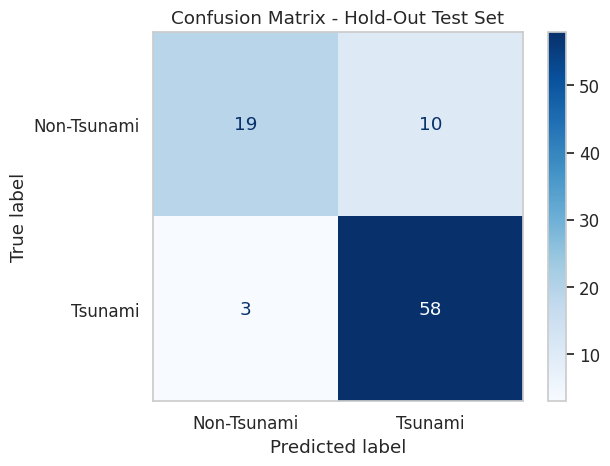


EVALUATION COMPLETE.


In [17]:
# ==============================================================================
# STEP 5: FINAL EVALUATION ON HOLD-OUT TEST SET
# ==============================================================================
print("\n" + "="*70)
print("STEP 5: FINAL EVALUATION ON THE HOLD-OUT TEST SET")
print("="*70)

# 'best_model_tuned' is the optimized pipeline (Gradient Boosting) from Step 4.5
# 'X_test' and 'y_test' are the reserved test set for final evaluation

# 1. Final predictions
y_pred_final = best_model_tuned.predict(X_test)
y_proba_final = best_model_tuned.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# 2. Classification report
print("\n--- Final Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_final, 
                            target_names=['Non-Tsunami', 'Tsunami']))

# 3. Final ROC-AUC score
final_roc_auc = roc_auc_score(y_test, y_proba_final)
print(f"\n✓ Final ROC-AUC (Test Set): {final_roc_auc:.4f}")

# 4. Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_model_tuned, 
    X_test, 
    y_test, 
    cmap='Blues', 
    display_labels=['Non-Tsunami', 'Tsunami']
)
plt.title('Confusion Matrix - Hold-Out Test Set')
plt.grid(False)
plt.show()

print("\nEVALUATION COMPLETE.")

## 5. Final Conclusion & Model Interpretation
______________________________________________
### Executive Summary

The objective of this project was to predict tsunami potential from seismic features using machine learning.
The final **optimized Gradient Boosting** model delivers excellent performance while following a safety-first philosophy — prioritizing life-saving sensitivity over minimal false alarms.

Final results (on unseen test data):

🌊 - Tsunami **F1-Score: 0.90**

⚠️ - Tsunami **Recall: 0.95**

📈 - Overall **ROC-AUC: 0.9011**

### Model Reliability — A “Safety-First” Success

The model’s strength lies not only in its high F1-score but in its intentional trade-off between sensitivity and precision.

Stability:
The test performance closely matches cross-validation results (CV F1 = 0.9047), confirming the model generalizes well and is not overfitted.

Trade-Off Strategy:

- Tsunami (Class 1) Recall: 0.95 → Correctly identifies 95% of real tsunamis.

- Non-Tsunami (Class 0) Recall: 0.66 → Accepts moderate false positives (34%) to ensure dangerous events are rarely missed.

This behavior is deliberate: the model is designed to err on the **side of caution**, prioritizing human safety over perfect accuracy.

### Focus on Recall metric

In this context, Recall is the most critical metric because the cost of missing a real tsunami (False Negative) is catastrophic.

Error Type	Meaning	Cost
False Positive (FP)	Predicts a tsunami that doesn’t occur	Inconvenience, unnecessary alerts
False Negative (FN)	Predicts “No Tsunami” when one occurs	Disaster — lives at risk

Our model achieves 95% Recall, meaning it successfully **detects 95% of real tsunamis** and misses only 5%.


### Overcoming the Small Dataset Challenge

A major technical hurdle was the limited dataset size, which increases the risk of overfitting.
To ensure reliability, I implemented several key strategies:

- Data Curation: Removed pre-2012 biased records to prevent learning non-physical correlations (data leakage).

- Robust Validation: Used Repeated **Stratified K-Fold Cross-Validation** (10 splits × 3 repeats) to stabilize performance estimates.

- Leakage-Proof Pipelines: All preprocessing (ex. StandardScaler) was applied only on training folds using **sklearn.pipeline**.

- Targeted Hyperparameter Tuning: **GridSearchCV** was restricted to top-performing models (Gradient Boosting, Random Forest) to focus on real gains.

- Final Hold-Out Evaluation: A separate 20% test set was kept untouched until the final evaluation.

-------------------------------------------------------------------------------

### Core Competencies Demonstrated

- **Advanced Geospatial Feature Engineering** : Integrated external tectonic plate data using GeoPandas and engineered a physically grounded predictor (distance_to_fault_km) with proper CRS projection and distance computation.
  
- **Critical Exploratory Data Analysis (EDA)**: Identified and corrected a critical representation bias (the pre-2012 data anomaly).

- **Robust Validation Strategy**: Implemented RepeatedStratifiedKFold (Cross-Validation) to get reliable performance metrics from a small, imbalanced dataset, preventing overfitting.

- **Leak-Proof Preprocessing**: Ensured clean scaling via sklearn.pipeline inside each CV fold.

- **Metric-Driven Decision-Making**: Prioritized Recall to minimize false negatives (safety-first objective).

- **Comparative Model Benchmarking**: Evaluated 8 ML architectures in a controlled experiment.

- **Targeted Hyperparameter Tuning**: Tuned top-performing models (Gradient Boosting and Random Forest) via GridSearchCV.

- **End-to-End Model Interpretation**: Framed model performance (high tsunami recall, lower non-tsunami recall) as a deliberate trade-off aligned with risk mitigation priorities.


-----------------------------------------------------------------------------------------------
This project delivered a robust tsunami prediction model that **correctly classifies about 90% of events overall and detects 95% of tsunamis** : a reliable, safety-first system built on rigorous data science, machine learning and geospatial intelligence.